In [2]:
import cv2
import matplotlib.pyplot as plt

In [9]:
### define file path
img_path = '/content/Centerline_Rumble_Strip.jpg'
# load color image
bgr_img = cv2.imread(img_path)

In [10]:
bgr_img.shape

(2304, 3072, 3)

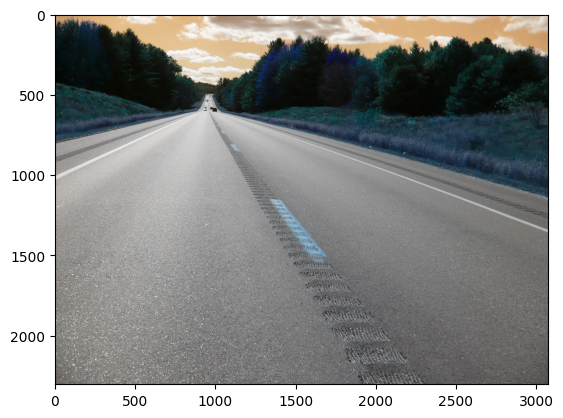

In [13]:
plt.imshow(bgr_img)

In [12]:
# convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

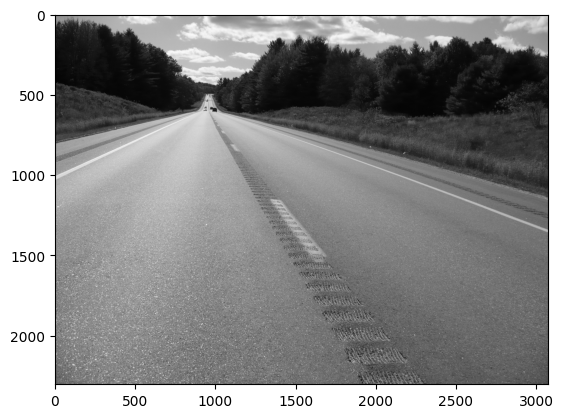

In [16]:
plt.imshow(gray_img, cmap='gray')

In [17]:
# normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")

In [20]:
gray_img /= 255

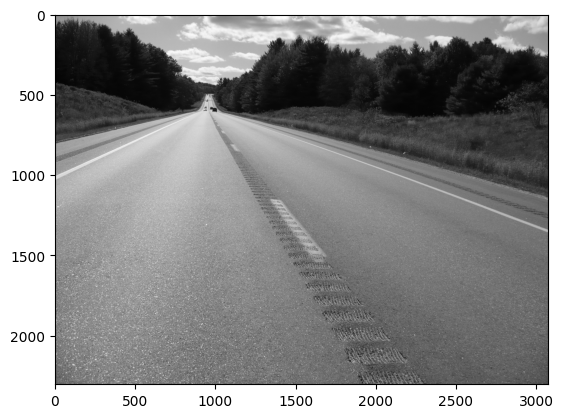

In [21]:
plt.imshow(gray_img, cmap='gray')

In [23]:
import numpy as np
filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])

# define four filters

filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

In [57]:
filters.shape

(4, 4, 4)

In [45]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):

    def __init__(self, weight):
        super(Net, self).__init__()
        # initializes the weights of the convolutional layer to be the weights of the 4 defined filters
        k_height, k_width = weight.shape[2:]
        # assumes there are 4 grayscale filters
        self.conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
                ### Defining the filter parameters explicitly
        self.conv.weight = torch.nn.Parameter(weight)

    def forward(self, x):
        # calculates the output of a convolutional layer
        # pre- and post-activation
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)

        # returns both layers
        return conv_x, activated_x

In [46]:
import torch
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)

weight.shape

torch.Size([4, 1, 4, 4])

In [47]:
# Instantiate the model
model = Net(weight)
print(model)

Net(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [48]:
# convert the image into an input Tensor
print(gray_img.shape)
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

print(gray_img_tensor.shape)

(2304, 3072)
torch.Size([1, 1, 2304, 3072])


In [50]:
# get the convolutional layer (pre and post activation)
conv_layer, activated_layer = model(gray_img_tensor)
print(f'Shape before Activation: {conv_layer.shape}')
print(f'Shape after Activation: {activated_layer.shape}')

Shape before Activation: torch.Size([1, 4, 2301, 3069])
Shape after Activation: torch.Size([1, 4, 2301, 3069])


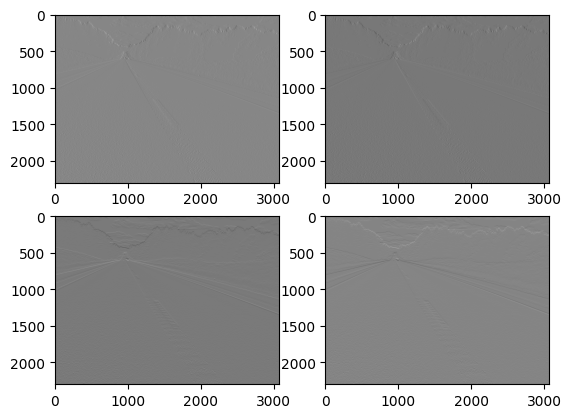

In [59]:
for i in range(filters.shape[0]):
  plt.subplot(2,2,i+1)
  plt.imshow(conv_layer[0,i,:,:].detach().numpy(), cmap='gray')


plt.show();

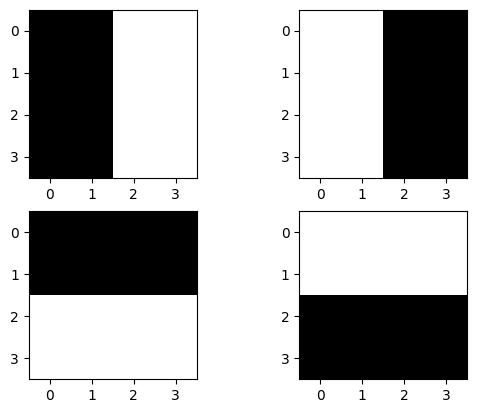

In [56]:
# Images of the kernels
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(filters[i], cmap='gray')

plt.show();

# **Working with CIFAR10 Dataset**

In [60]:
from torchvision import datasets
from torchvision.transforms import transforms

In [61]:
# Set the transformation pipeline
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
])


In [62]:
# Load train and test datasets
train_data = datasets.CIFAR10('data',train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data',train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:07<00:00, 22.7MB/s]


In [63]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [65]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
       # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)

        return x

In [67]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
